<a href="https://colab.research.google.com/github/borbysh/Momentum-QNG/blob/main/Quantum_Machine_Learning/tutorial_noisy_circuit_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 105.7 MB/s eta 0:00:00


Adopted from this thread: https://discuss.pennylane.ai/t/training-with-qng-optimizer-on-circuit-with-data-argument/2067

In [20]:
import pennylane as qml
from pennylane import numpy as np

Nwires = 5
dev = qml.device("default.qubit", wires=Nwires)

@qml.qnode(dev)
def circuit(params, data):
    qml.AngleEmbedding(data, wires=[i for i in range(Nwires)])
    qml.StronglyEntanglingLayers(params, wires=[i for i in range(Nwires)])
    return qml.expval(qml.PauliZ(Nwires-1))

#data = np.random.random([3], requires_grad=False)
#params = np.random.random(qml.StronglyEntanglingLayers.shape(3, 3), requires_grad=True)

#def cost(params, single_sample):
     #return (1 - circuit(params, single_sample)) ** 2
Nbatch = 10
data = [np.random.random([Nwires], requires_grad=False) for _ in range(Nbatch)]
params = np.random.random(qml.StronglyEntanglingLayers.shape(Nwires, Nwires), requires_grad=True)

def cost(params, data):
     return np.sum((1 - circuit(params, single_sample)) ** 2 for single_sample in data) / Nbatch
opt = qml.MomentumQNGOptimizer(0.1)
#opt = qml.AdamOptimizer()
for it in range(10):
    for sample in data: #range(10):
        cost_fn = lambda p: cost(p, data)
        metric_fn = lambda p: qml.metric_tensor(circuit, approx="block-diag")(p, sample) #data)

        params, loss = opt.step_and_cost(cost_fn, params,  metric_tensor_fn=metric_fn)

    print(f"Epoch: {it} | Loss: {loss} |")

Epoch: 0 | Loss: 0.8594869271753922 |
Epoch: 1 | Loss: 0.5573272778190229 |
Epoch: 2 | Loss: 0.273154129617792 |
Epoch: 3 | Loss: 0.17041369926917843 |
Epoch: 4 | Loss: 0.11234116662389881 |
Epoch: 5 | Loss: 0.09555415559342863 |
Epoch: 6 | Loss: 0.025514533790092393 |
Epoch: 7 | Loss: 0.007804297029493831 |
Epoch: 8 | Loss: 0.0034753717031748557 |
Epoch: 9 | Loss: 0.0026524499486658493 |


In [3]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
!pip install pennylane
!pip install pennylane_cirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.0 MB/s eta 0:00:00


# Optimizing noisy circuits with Cirq

::: meta
:property=\"og:description\": Learn how noise can affect the
optimization and training of quantum computations.
:property=\"og:image\":
<https://pennylane.ai/qml/_static/demonstration_assets/noisy_circuit_optimization_thumbnail.png>
:::

::: related
pytorch_noise PyTorch and noisy devices
:::

![](https://github.com/borbysh/Momentum-QNG/blob/main/_static/demonstration_assets/noisy_circuit_optimization/noisy_qubit.png?raw=1){.align-center
width="90.0%"}

Until we have fault-tolerant quantum computers, we will have to learn to
live with noise. There are lots of exciting ideas and algorithms in
quantum computing and quantum machine learning, but how well do they
survive the reality of today\'s noisy devices?

## Background

Quantum pure-state simulators are great and readily available in a
number of quantum software packages. They allow us to experiment,
prototype, test, and validate algorithms and research ideas---up to a
certain number of qubits, at least.

But present-day hardware is not ideal. We\'re forced to confront
decoherence, bit flips, amplitude damping, and so on. Does the presence
of noise in near-term devices impact their use in, for example,
`variational quantum algorithms </glossary/variational_circuit>`{.interpreted-text
role="doc"}? Won\'t our models, trained so carefully in simulators, fall
apart when we run on noisy devices?

In fact, there is some optimism that variational algorithms may be the
best type of algorithms on near-term devices, and could have an in-built
adaptability to noise that more rigid textbook algorithms do not
possess. Variational algorithms are somewhat robust against the fact
that the device they are run on may not be ideal. Being variational in
nature, they can be tuned to \"work around\" noise to some extent.

Quantum machine learning leverages a lot of tools from its classical
counterpart. Fortunately, there is great evidence that machine learning
algorithms can not only be robust to noise, but can even benefit from
it! Examples include the use of [reduced-precision arithmetic in deep
learning](https://dl.acm.org/doi/abs/10.5555/3045118.3045303), the
strong performance of [stochastic gradient
descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), and
the use of \"dropout\" noise to [prevent
overfitting](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

With this evidence to motivate us, we can still hope to find, extract,
and work with the underlying quantum \"signal\" that is influenced by a
device\'s inherent noise.

## Noisy circuits: creating a Bell state

Let\'s consider a simple quantum circuit which performs a standard
quantum information task: the creation of an entangled state and the
measurement of a [Bell
inequality](https://en.wikipedia.org/wiki/Bell%27s_theorem) (also known
as the [CHSH
inequality](https://en.wikipedia.org/wiki/CHSH_inequality)).

Since we\'ll be dealing with noise, we\'ll need to use a simulator that
supports noise and density-state representations of quantum states (in
contrast to many simulators, which use a pure-state representation).

Fortunately, [Cirq](https://cirq.readthedocs.io) provides mixed-state
simulators and noisy operations natively, so we can use the
[PennyLane-Cirq plugin](https://pennylane-cirq.readthedocs.io) to carry
out our noisy simulations.


In [4]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

dev = qml.device("cirq.mixedsimulator", wires=2, shots=1000)

# CHSH observables
A1 = qml.PauliZ(0)
A2 = qml.PauliX(0)
B1 = qml.Hermitian(np.array([[1, 1], [1, -1]]) / np.sqrt(2), wires=1)
B2 = qml.Hermitian(np.array([[1, -1], [-1, -1]]) / np.sqrt(2), wires=1)
CHSH_observables = [A1 @ B1, A1 @ B2, A2 @ B1, A2 @ B2]


# subcircuit for creating an entangled pair of qubits
def bell_pair():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])


# circuits for measuring each distinct observable
@qml.qnode(dev)
def measure_A1B1():
    bell_pair()
    return qml.expval(A1 @ B1)


@qml.qnode(dev)
def measure_A1B2():
    bell_pair()
    return qml.expval(A1 @ B2)


@qml.qnode(dev)
def measure_A2B1():
    bell_pair()
    return qml.expval(A2 @ B1)


@qml.qnode(dev)
def measure_A2B2():
    bell_pair()
    return qml.expval(A2 @ B2)


# now we measure each circuit and construct the CHSH inequality
expvals = [measure_A1B1(), measure_A1B2(), measure_A2B1(), measure_A2B2()]

# The CHSH operator is A1 @ B1 + A1 @ B2 + A2 @ B1 - A2 @ B2
CHSH_expval = np.sum(expvals[:3]) - expvals[3]
print(CHSH_expval)

2.9139999999999997


The output here is $2\sqrt{2},$ which is the maximal value of the CHSH
inequality. States which have a value $\langle CHSH \rangle \geq 2$ can
safely be considered \"quantum\".

::: note
::: title
Note
:::

In this situation \"quantum\" means that there is no [local hidden
variable
theory](https://en.wikipedia.org/wiki/Local_hidden-variable_theory)
which could produce these measurement outcomes. It does not strictly
mean the presence of entanglement.
:::

Now let\'s turn up the noise! 📢 📢 📢

Cirq provides a number of noisy channels that are not part of PennyLane
core. This is no issue, as the
[PennyLane-Cirq](https://pennylane-cirq.readthedocs.io) plugin provides
these and allows them to be used directly in PennyLane circuit
declarations.


In [5]:
from pennylane_cirq import ops as cirq_ops

# Note that the 'Operation' op is a generic base class
# from PennyLane core.
# All other ops are provided by Cirq.
available_ops = [op for op in dir(cirq_ops) if not op.startswith("_")]
print("\n".join(available_ops))

AmplitudeDamp
BitFlip
Depolarize
Operation
PhaseDamp
PhaseFlip


PennyLane operations and external framework-specific operations can be
interwoven freely in circuits that use that plugin\'s device for
execution. In this case, the Cirq-provided channels can be used with
Cirq\'s mixed-state simulator.

We\'ll use the `BitFlip` channel, which has the effect of randomly
flipping the qubits in the computational basis.


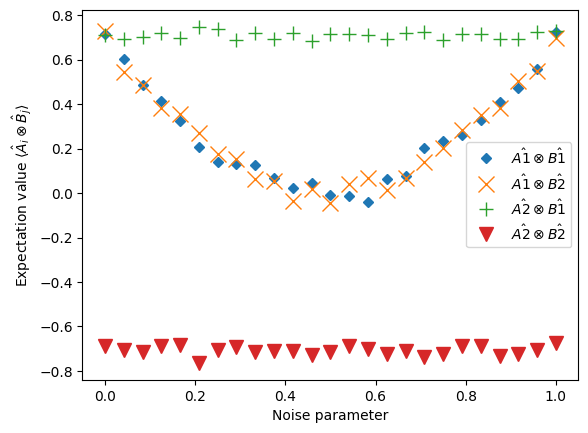

In [6]:
noise_vals = np.linspace(0, 1, 25)

CHSH_vals = []
noisy_expvals = []

for p in noise_vals:
    # we overwrite the bell_pair() subcircuit to add
    # extra noisy channels after the entangled state is created
    def bell_pair():
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0, 1])
        cirq_ops.BitFlip(p, wires=0)
        cirq_ops.BitFlip(p, wires=1)

    # measuring the circuits will now use the new noisy bell_pair() function
    expvals = [measure_A1B1(), measure_A1B2(), measure_A2B1(), measure_A2B2()]
    noisy_expvals.append(expvals)
noisy_expvals = np.array(noisy_expvals)
CHSH_expvals = np.sum(noisy_expvals[:, :3], axis=1) - noisy_expvals[:, 3]

# Plot the individual observables
plt.plot(noise_vals, noisy_expvals[:, 0], "D", label=r"$\hat{A1}\otimes \hat{B1}$", markersize=5)
plt.plot(noise_vals, noisy_expvals[:, 1], "x", label=r"$\hat{A1}\otimes \hat{B2}$", markersize=12)
plt.plot(noise_vals, noisy_expvals[:, 2], "+", label=r"$\hat{A2}\otimes \hat{B1}$", markersize=10)
plt.plot(noise_vals, noisy_expvals[:, 3], "v", label=r"$\hat{A2}\otimes \hat{B2}$", markersize=10)
plt.xlabel("Noise parameter")
plt.ylabel(r"Expectation value $\langle \hat{A}_i\otimes\hat{B}_j\rangle$")
plt.legend()
plt.show()

By adding the bit-flip noise, we have degraded the value of the CHSH
observable. The first two observables $\hat{A}_1\otimes \hat{B}_1$ and
$\hat{A}_1\otimes \hat{B}_2$ are sensitive to this noise parameter.
Their value is weakened when the noise parameter is not 0 or 1 (note
that the the CHSH operator is symmetric with respect to bit flips).

The latter two observables, on the other hand, are seemingly unaffected
by the noise at all.

We can see that even when noise is present, there may still be subspaces
or observables which are minimally affected or unaffected. This gives us
some hope that variational algorithms can learn to find and exploit such
noise-free substructures on otherwise noisy devices.

We can also plot the CHSH observable in the noisy case. Remember, values
greater than 2 can safely be considered \"quantum\".


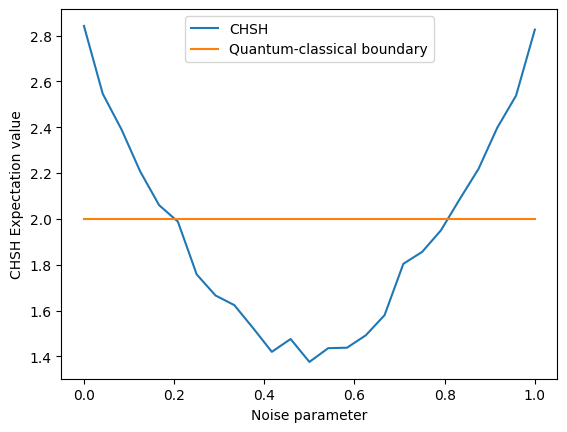

In [7]:
plt.plot(noise_vals, CHSH_expvals, label="CHSH")
plt.plot(noise_vals, 2 * np.ones_like(noise_vals), label="Quantum-classical boundary")
plt.xlabel("Noise parameter")
plt.ylabel("CHSH Expectation value")
plt.legend()
plt.show()

Too much noise (around 0.2 in this example), and we lose the quantumness
we created in our circuit. But if we only have a little noise, the
quantumness undeniably remains. So there is still hope that quantum
algorithms can do something useful, even on noisy near-term devices, so
long as the noise is not high.

::: note
::: title
Note
:::

In Google\'s quantum supremacy paper, they were able to show that some
small signature of quantumness remained in their computations, even
after a deep many-qubit noisy circuit was executed.
:::


# Optimizing noisy circuits

Now, how does noise affect the ability to optimize or train a
variational circuit?

Let\'s consider an analog of the basic
`qubit rotation tutorial <demos/tutorial_qubit_rotation>`{.interpreted-text
role="doc"}, but where we add an extra noise channel after the gates.

::: note
::: title
Note
:::

We model the noise process as the application of ideal noise-free gates,
followed by the action of a noisy channel. This is a common technique
for modelling noise, but may not be appropriate for all situations.
:::


In [8]:
@qml.qnode(dev)
def circuit(gate_params, noise_param=0.0):
    qml.RX(gate_params[0], wires=0)
    qml.RY(gate_params[1], wires=0)
    cirq_ops.Depolarize(noise_param, wires=0)
    return qml.expval(qml.PauliZ(0))


gate_pars = [0.54, 0.12]
print("Expectation value:", circuit(gate_pars))

Expectation value: 0.868


In this case, the depolarizing channel degrades the qubit\'s density
matrix $\rho$ towards the state

$$\rho' = \tfrac{1}{3}\left[X\rho X + Y\rho Y + Z\rho Z\right]$$

(at the value $p=\frac{3}{4},$ it passes through the maximally mixed
state). We can see this in our circuit by looking at how the final
`~pennylane.ops.PauliZ`{.interpreted-text role="class"} expectation
value changes as a function of the noise strength.


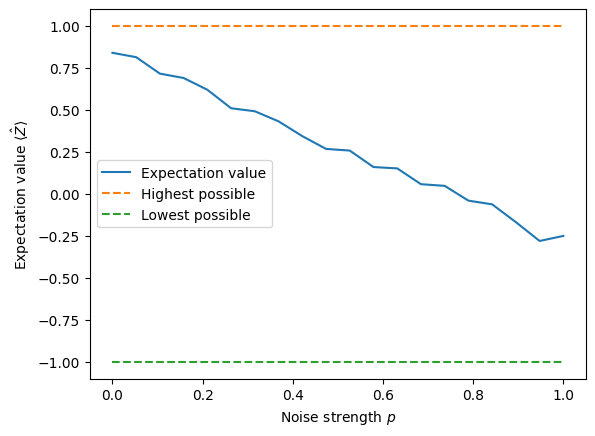

In [9]:
noise_vals = np.linspace(0.0, 1.0, 20)
expvals = [circuit(gate_pars, noise_param=p) for p in noise_vals]

plt.plot(noise_vals, expvals, label="Expectation value")
plt.plot(noise_vals, np.ones_like(noise_vals), "--", label="Highest possible")
plt.plot(noise_vals, -np.ones_like(noise_vals), "--", label="Lowest possible")
plt.ylabel(r"Expectation value $\langle \hat{Z} \rangle$")
plt.xlabel(r"Noise strength $p$")
plt.legend()
plt.show()

Let\'s fix the noise parameter and see how the noise affects the
optimization of our circuit. The goal is the same as the
`qubit rotation tutorial <demos/tutorial_qubit_rotation>`{.interpreted-text
role="doc"}, i.e., to tune the qubit state until it has a `PauliZ`
expectation value of $-1$ (the lowest possible).


In [10]:
# declare the cost functions to be optimized
def cost(x):
    return circuit(x, noise_param=0.0)


def noisy_cost(x):
    return circuit(x, noise_param=0.3)


# initialize the optimizer
#opt = qml.GradientDescentOptimizer(stepsize=0.4)
opt = qml.QNGOptimizer(stepsize=0.4)

# set the number of steps
steps = 100
# set the initial parameter values
init_params = np.array([0.011, 0.055], requires_grad=True)
noisy_circuit_params = init_params
params = init_params

for i in range(steps):
    # update the circuit parameters
    # we can optimize both in the same training loop
    metric_fn = qml.metric_tensor(circuit, approx="block-diag")
    params = opt.step(cost, params)
    noisy_circuit_params = opt.step(noisy_cost, noisy_circuit_params)

    if (i + 1) % 5 == 0:
        print(
            "Step {:5d}. Cost: {: .7f}; Noisy Cost: {: .7f}".format(
                i + 1, cost(params), noisy_cost(noisy_circuit_params)
            )
        )

print("\nOptimized rotation angles (noise-free case):")
print("({: .7f}, {: .7f})".format(*params))
print("Optimized rotation angles (noisy case):")
print("({: .7f}, {: .7f})".format(*noisy_circuit_params))

ValueError: The objective function must be encoded as a single QNode for the natural gradient to be automatically computed. Otherwise, metric_tensor_fn must be explicitly provided to the optimizer.

There are a couple interesting observations here:

i)  The noisy circuit isn\'t able to achieve the same final cost
    function value as the ideal circuit. This is because the noise
    causes the state to become irreversibly mixed. Mixed states can\'t
    achieve the same extremal expectation values as pure states.
ii) However, both circuits still converge to the *same parameter values*
    $(0,\pi),$ despite having different final states.

It could have been the case that noisy devices irreparably damage the
optimization of variational circuits, steering us towards parameter
values which are not at all useful. Luckily, at least for the simple
example above, this is not the case. *Optimizations on noisy devices can
still lead to similar parameter values as when we run on ideal devices.*


# Understanding the effect of noisy channels

Let\'s dig a bit into the underlying quantum information theory to
understand better what\'s happening. Expectation values of
`variational circuits </glossary/variational_circuit>`{.interpreted-text
role="doc"}, like the one we are measuring, are composed of three
pieces:

i)  an initial quantum state $\rho$ (usually the zero state);
ii) a parameterized unitary transformation $U(\theta)$); and
iii) measurement of a final observable $\hat{B}.$

The equation for the expectation value is given by the [Born
rule](https://en.wikipedia.org/wiki/Born_rule):

$$\langle \hat{B} \rangle (\theta) =
        \mathrm{Tr}(\hat{B}U(\theta)\rho U^\dagger(\theta)).$$

When optimizing, we can compute gradients of many common gates using the
`parameter-shift rule </glossary/parameter_shift>`{.interpreted-text
role="doc"}:

$$\nabla_\theta\langle \hat{B} \rangle(\theta)
   =  \frac{1}{2}
         \left[
             \langle \hat{B} \rangle\left(\theta + \frac{\pi}{2}\right)
           - \langle \hat{B} \rangle\left(\theta - \frac{\pi}{2}\right)
         \right].$$

In our example, the parametrized unitary $U(\theta)$ is split into two
gates, $U = U_2 U_1,$ where $U_1=R_X$ and $U_1=R_Y,$ and each takes an
independent parameter $\theta_i.$

What happens when we apply a noisy channel $\Lambda$ after the gates? In
this case, the expectation value is now taken with respect to the noisy
circuit:

$$\langle \hat{B} \rangle (\theta) =
       \mathrm{Tr}\left(\hat{B}\Lambda\left[
                      U(\theta)\rho U^\dagger(\theta)
                  \right]\right).$$

Thus, we can treat it as the expectation value of the same observable,
but with respect to a different state
$\rho' = \Lambda\left[U(\theta)\rho U^\dagger(\theta)\right].$

Alternatively, using the Heisenberg picture, we can transfer the channel
$\Lambda$ acting on the state $U(\theta)\rho U^\dagger(\theta)$ into the
*adjoint channel* $\Lambda^\dagger$ acting on the observable $\hat{B},$
transforming it to a new observable
$\hat{B} = \Lambda^\dagger[\hat{B}]=\hat{B}'.$

With the channel present, the expectation value can be interpreted as if
we had the same variational state, but measured a different observable:

$$\langle \hat{B} \rangle (\theta) =
       \mathrm{Tr}(\hat{B}'U(\theta)\rho U^\dagger(\theta)) =
       \langle \hat{B}' \rangle (\theta).$$

This has immediate consequences for the parameter-shift rule. With the
channel present, we have simply

$$\nabla_\theta\langle \hat{B} \rangle(\theta)
  =  \frac{1}{2}
        \left[
            \langle \hat{B}' \rangle\left(\theta + \frac{\pi}{2}\right)
          - \langle \hat{B}' \rangle\left(\theta - \frac{\pi}{2}\right)
        \right].$$

In other words, the parameter-shift rule continues to hold for all
gates, even when we have additional noise!

::: note
::: title
Note
:::

In the above derivation, we implicitly assumed that the channel does not
depend on the variational circuit\'s parameters. If the channel depended
on the particular state, or if it depended on the parameters $\theta,$
we would need to be more careful.
:::

Let\'s confirm the above derivation with an example.


In [ ]:
angles = np.linspace(0, 2 * np.pi, 50)
theta2 = np.pi / 4


def param_shift(theta1):
    return 0.5 * (
        noisy_cost([theta1 + np.pi / 2, theta2]) - noisy_cost([theta1 - np.pi / 2, theta2])
    )


noisy_expvals = [noisy_cost([theta1, theta2]) for theta1 in angles]
noisy_param_shift = [param_shift(theta1) for theta1 in angles]

plt.plot(angles, noisy_expvals, label="Expectation value")  # looks like 0.4 * cos(phi)
plt.plot(angles, noisy_param_shift, label="Parameter-shift value")  # looks like -0.4 * sin(phi)
plt.ylabel(r"Expectation value $\langle \hat{Z} \rangle$")
plt.xlabel(r"Angle $\theta_1$")
plt.legend()
plt.show()

By inspecting the two curves, we can see that the parameter-shift rule
gives the correct gradient of the expectation value, even with the
presence of the noisy channel!

In this example, the influence of the channel is to attenuate the
maximal amplitude that the qubit state can achieve ($\approx 0.4$). But
even though the qubit\'s amplitude is attenuated, the gradient computed
by the parameter-shift rule still \"points in the right direction\".

This backs up the observation we made earlier that the result of the
optimization gave the correct values for the angle parameters, but the
value of the final cost function was lower than the noise-free case.


# Interpreting noisy circuit optimizations

Despite the observations that we can compute gradients for noisy
channels, and that optimization may lead to the same parameter values
for both noise-free and noisy circuits, we must still remain cautious in
how we interpret the results.

We can evaluate the correct gradient for the expectation value

$$\langle \hat{B} \rangle =
       \mathrm{Tr}\left(\hat{B}\Lambda\left[
                      U(\theta)\rho U^\dagger(\theta)
                  \right]\right),$$

but, because the noisy channel is present, *this expectation value may
not reflect the actual expectation value we wanted to compute*. This is
important to keep in mind for certain algorithms that have a physical
interpretation for the variational circuit.

For example, in the
`variational quantum eigensolver <demos/tutorial_vqe>`{.interpreted-text
role="doc"}, we want to find the ground-state energy of a physical
system. If there is an appreciable amount of noise present, the state we
are optimizing will necessarily become mixed, and we should be careful
interpreting the optimum value as the exact ground-state energy.


# References
